In [1]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='--conf spark.sql.catalogImplementation=in-memory pyspark-shell'
os.environ["PYSPARK_PYTHON"]='/opt/anaconda/envs/bd9/bin/python'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.7-src.zip'))
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.3
      /_/

Using Python version 3.6.5 (default, Apr 29 2018 16:14:56)
SparkSession available as 'spark'.


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Пусть вам дан следующий SQL-запрос
```sql

select * from logs l join ips r
on l.ip == r.ip
```

### Таблица `logs` находится в HDFS по пути `/user/pavel.klemenkov/lectures/lecture02/data/logsM.txt`, таблица `ips`  находится в HDFS по пути `/user/pavel.klemenkov/lectures/lecture02/data/ipDataM.txt`

## 1. Выполните этот запрос в Spark SQL, предварительно зарегистрировав таблицы

In [4]:
from pyspark.sql.types import *

In [5]:
log_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("timestamp", LongType()),
    StructField("url", StringType()),
    StructField("size", IntegerType()),
    StructField("code", IntegerType()),
    StructField("ua", StringType())
])

In [6]:
ip_schema = StructType(fields=[
    StructField("ip", StringType()),
    StructField("region", StringType())
])

In [7]:
logs = spark.read.csv("/user/pavel.klemenkov/lectures/lecture02/data/logsM.txt", sep="\t", schema=log_schema)

In [8]:
ips = spark.read.csv("/user/pavel.klemenkov/lectures/lecture02/data/ipDataM.txt", sep="\t", 
                    schema=ip_schema)

In [9]:
logs.registerTempTable("logs")

In [10]:
ips.registerTempTable("ips")

In [11]:
q = """
select * from logs l join ips r
on l.ip == r.ip
"""

In [12]:
spark.sql(q).show()

+-------------+--------------+--------------------+----+----+--------------------+-------------+--------------------+
|           ip|     timestamp|                 url|size|code|                  ua|           ip|              region|
+-------------+--------------+--------------------+----+----+--------------------+-------------+--------------------+
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|33.49.147.163|      Irkutsk Oblast|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|33.49.147.163|         Omsk Oblast|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|33.49.147.163|Nizhny Novgorod O...|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|33.49.147.163|              Jewish|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|33.49.147.163|      Kamchatka Krai|
|33.49.147.163|20140101014611|http://news.rambl...| 378|

## 2. Теперь перепешите этот запрос с использованием DataFrame API

In [14]:
logs.join(ips, on="ip", how="inner").show()

+-------------+--------------+--------------------+----+----+--------------------+--------------------+
|           ip|     timestamp|                 url|size|code|                  ua|              region|
+-------------+--------------+--------------------+----+----+--------------------+--------------------+
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|      Irkutsk Oblast|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|         Omsk Oblast|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|Nizhny Novgorod O...|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|              Jewish|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|      Kamchatka Krai|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Safari/5.0 (compa...|          Altai Krai|
|33.49.147.163|20140101014611|http://news.rambl...| 378| 431|Saf

## 3. Посчитайте гистограмму распределения кодов ответа в логе доступа. Отсуртируйте результат по каунту. Наибольшая сумма сверху

In [16]:
logs.groupBy("code").count().orderBy("count", ascending=False).show()

+----+-----+
|code|count|
+----+-----+
| 302|  323|
| 307|  182|
| 205|  181|
| 502|  181|
| 504|  177|
| 207|  174|
| 403|  174|
| 415|  174|
| 408|  172|
| 200|  170|
| 505|  169|
| 422|  169|
| 409|  167|
| 503|  165|
| 418|  165|
| 507|  164|
| 301|  163|
| 456|  162|
| 226|  161|
| 511|  161|
+----+-----+
only showing top 20 rows



## 4. Изобразите гистограмму кодов на графике

In [17]:
pdf = logs.groupBy("code").count().orderBy("count", ascending=False).toPandas()

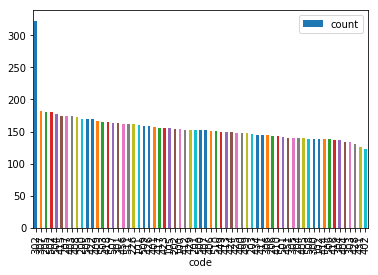

In [19]:
pdf.plot.bar(x="code", y="count")

## 5. Напишите запрос, который вернет распределение доменов среди запросов

In [20]:
from pyspark.sql.functions import pandas_udf

In [35]:
@pandas_udf(StringType())
def extract_domain(urls):
    return urls.apply(lambda u: urlparse(u).netloc)

In [36]:
logs.withColumn("domain", extract_domain("url")).groupBy("domain").count()\
    .orderBy("count", ascending=False).show()

+---------------+-----+
|         domain|count|
+---------------+-----+
|       lenta.ru| 2058|
|   news.mail.ru| 2035|
| news.yandex.ru| 2015|
|     newsru.com| 2001|
|news.rambler.ru| 1983|
+---------------+-----+



In [25]:
from urllib.parse import urlparse

In [26]:
urlparse("http://ya.ru")

ParseResult(scheme='http', netloc='ya.ru', path='', params='', query='', fragment='')

In [27]:
spark.udf.register("f", f)

<function __main__.f(s)>